# Dataset

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

    actinic keratosis
    basal cell carcinoma
    dermatofibroma
    melanoma
    nevus
    pigmented benign keratosis
    -seborrheic keratosis
    squamous cell carcinoma
    vascular lesion

# Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# Importing Skin Cancer Data

In [2]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

# Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(type(class_names), class_names)


<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

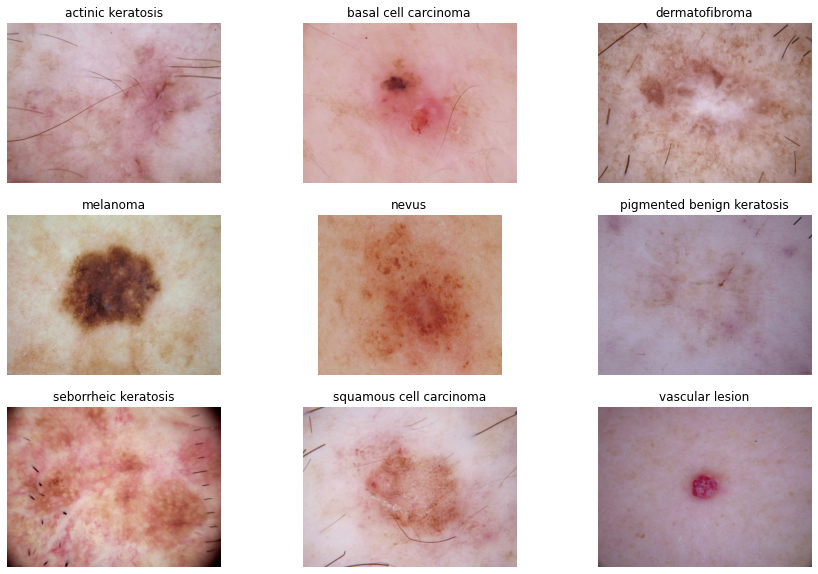

In [8]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [9]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


Check the configuration of gpu and use gpu.

In [10]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

# Using data augmentation

In [11]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

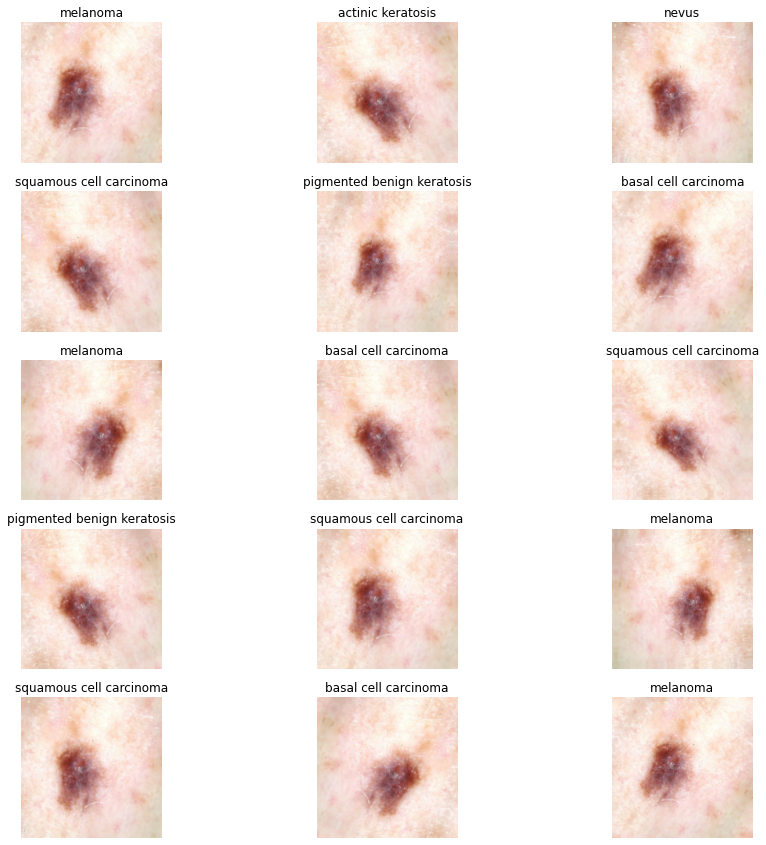

In [13]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

# Create the model, compile and train the model


```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

### Compiling the model

In [15]:
## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0

### Training the model

In [17]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 169ms/step - loss: 2.1575 - accuracy: 0.2066 - val_loss: 1.7737 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 1s 17ms/step - loss: 1.7689 - accuracy: 0.3623 - val_loss: 1.6818 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 1s 16ms/step - loss: 1.5607 - accuracy: 0.4511 - val_loss: 1.4391 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4012 - accuracy: 0.5204 - val_loss: 1.3985 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2929 - accuracy: 0.5445 - val_loss: 1.4364 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2962 - accuracy: 0.5469 - val_loss: 1.3203 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2428 - accuracy: 0.5421 - val_loss: 1.4068 - val_accuracy: 0.5235
Epoch 8/20


# Visualizing the results

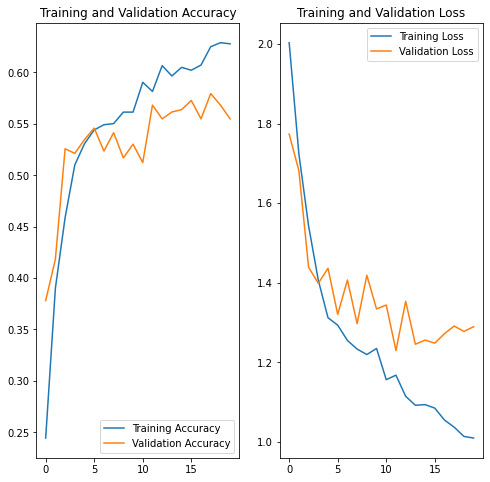

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [19]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [20]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


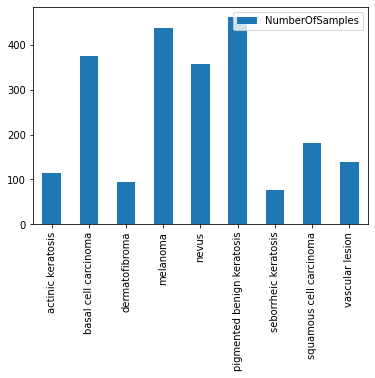

In [21]:
class_df.plot.bar()
plt.show()

# Rectify the class imbalance
#### Python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
!pip install Augmentor

In [23]:
import Augmentor

In [24]:
path_to_training_dataset = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5D481984D0>: 100%|██████████| 1000/1000 [00:32<00:00, 30.41 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61C827D3D0>: 100%|██████████| 1000/1000 [00:34<00:00, 29.38 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F612C369F90>: 100%|██████████| 1000/1000 [00:35<00:00, 28.52 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F612C307410>: 100%|██████████| 1000/1000 [03:13<00:00,  5.17 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F611C0F0710>: 100%|██████████| 1000/1000 [02:48<00:00,  5.92 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F611C0A0610>: 100%|██████████| 1000/1000 [00:33<00:00, 29.73 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F612C310B10>: 100%|██████████| 1000/1000 [01:20<00:00, 12.36 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61443B01D0>: 100%|██████████| 1000/1000 [00:33<00:00, 29.67 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F612C12E090>: 100%|██████████| 1000/1000 [00:33<00:00, 29.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
output_dir = pathlib.Path('/kaggle/working/')

In [26]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


# Train the model on the data created using Augmentor

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization)

In [30]:
num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compile your model (Choose optimizer and loss function appropriately)

In [31]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_4 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
activation_5 (Activation)    (None, 90, 90, 32)       

#### Train your model

In [33]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 28s 36ms/step - loss: 2.3727 - accuracy: 0.1419 - val_loss: 1.8756 - val_accuracy: 0.2928
Epoch 2/30
225/225 [==============================] - 3s 15ms/step - loss: 1.5221 - accuracy: 0.4172 - val_loss: 1.6839 - val_accuracy: 0.3750
Epoch 3/30
225/225 [==============================] - 3s 15ms/step - loss: 1.3297 - accuracy: 0.5012 - val_loss: 1.4862 - val_accuracy: 0.4533
Epoch 4/30
225/225 [==============================] - 3s 15ms/step - loss: 1.1895 - accuracy: 0.5533 - val_loss: 1.4357 - val_accuracy: 0.4817
Epoch 5/30
225/225 [==============================] - 3s 15ms/step - loss: 1.0879 - accuracy: 0.6001 - val_loss: 1.1627 - val_accuracy: 0.5711
Epoch 6/30
225/225 [==============================] - 3s 15ms/step - loss: 0.9609 - accuracy: 0.6565 - val_loss: 1.3107 - val_accuracy: 0.5211
Epoch 7/30
225/225 [==============================] - 3s 15ms/step - loss: 0.8893 - accuracy: 0.6827 - val_loss: 0.9601 - val_accuracy: 0.667

#### Visualize the model results

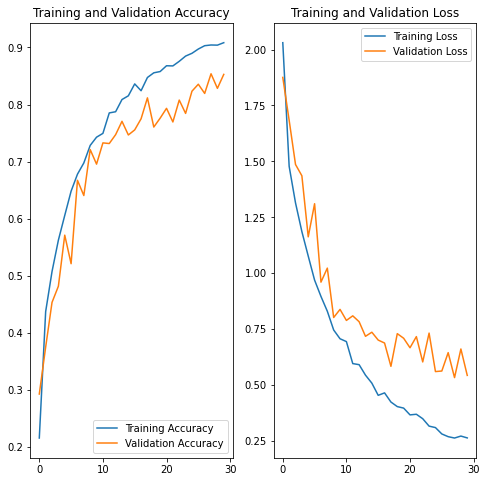

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We still have a overfitting model but we have much better accuracy than previous models.At end we have around 10% accuuracy difference between training and validation data.
Class rebalance helped us in getting better accuracy. 

We can reduce the overfitting by having a deeper model or add a data augmentation layer before it.

# Model with data augmentation and using Augmentor dataset

In [35]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [36]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [37]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_8 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)       

In [39]:
epochs = 50
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
225/225 [==============================] - 5s 17ms/step - loss: 1.9890 - accuracy: 0.2362 - val_loss: 1.3370 - val_accuracy: 0.4561
Epoch 2/50
225/225 [==============================] - 4s 16ms/step - loss: 1.4002 - accuracy: 0.4588 - val_loss: 1.2890 - val_accuracy: 0.5250
Epoch 3/50
225/225 [==============================] - 4s 16ms/step - loss: 1.2435 - accuracy: 0.5283 - val_loss: 1.1484 - val_accuracy: 0.5633
Epoch 4/50
225/225 [==============================] - 4s 16ms/step - loss: 1.2264 - accuracy: 0.5356 - val_loss: 1.0949 - val_accuracy: 0.5867
Epoch 5/50
225/225 [==============================] - 4s 16ms/step - loss: 1.1428 - accuracy: 0.5644 - val_loss: 1.0932 - val_accuracy: 0.5767
Epoch 6/50
225/225 [==============================] - 4s 16ms/step - loss: 1.0682 - accuracy: 0.6041 - val_loss: 0.9734 - val_accuracy: 0.6283
Epoch 7/50
225/225 [==============================] - 4s 16ms/step - loss: 0.9784 - accuracy: 0.6329 - val_loss: 1.0242 - val_accuracy: 0.6228

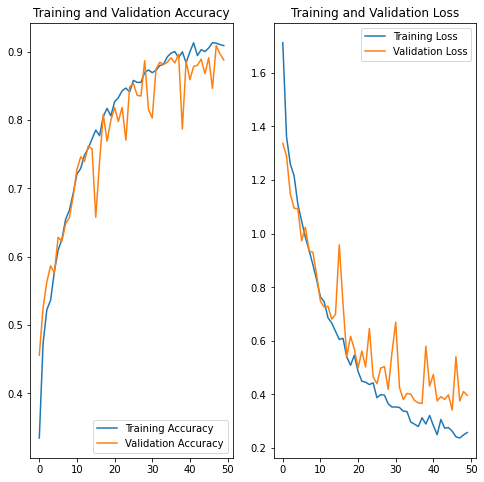

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Model evaluation

In [41]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0
 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0
 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1
 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1
 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0
 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1]
Labels:
 [5 0 4 2 4 7 0 1 0 3 5 0 1 4 7 7 3 5 4 2 2 0 7 2 0 1 4 5 5 2 1 3]


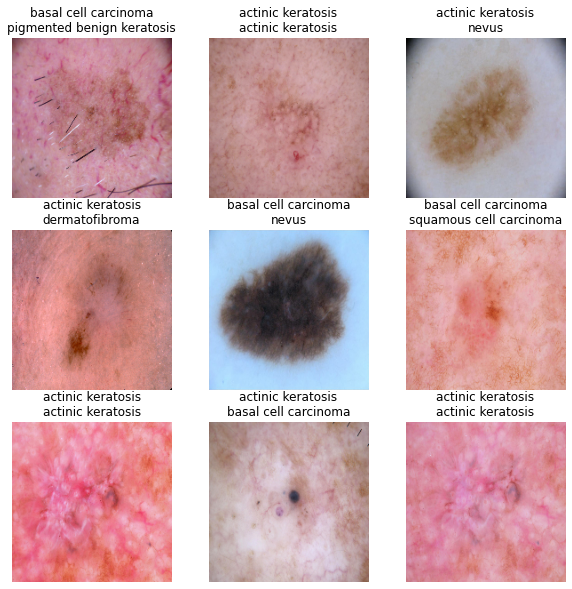

In [42]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")